In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=np.array([0.5, 0.1]),
    dt_base=0.002,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

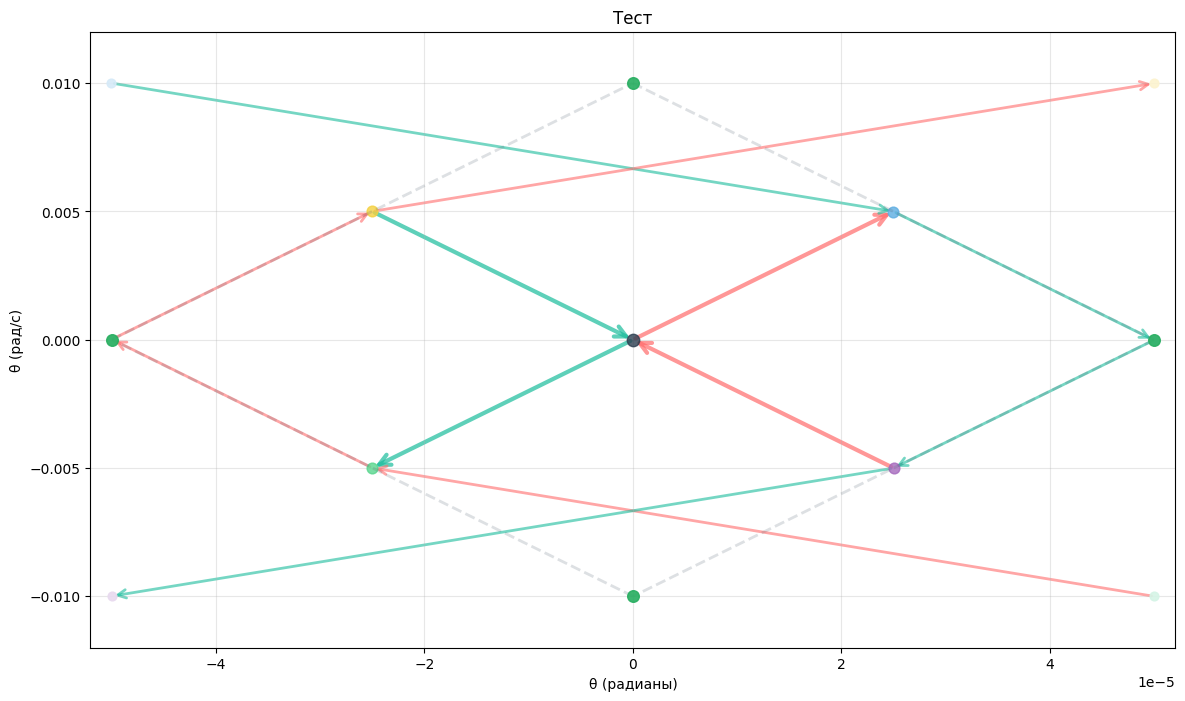

In [15]:
config_extreme = SporeTreeConfig(
    initial_position=np.array([0, 0.0]),
    dt_base=0.01,  # Очень большой шаг!
    dt_grandchildren_factor=1,  # Внуки в 2 раза меньше 
    show_debug=False
)


# Создаем дерево
tree_extreme = SporeTree(pendulum, config_extreme)

# Создаем всю структуру
children = tree_extreme.create_children(show=False)
grandchildren = tree_extreme.create_grandchildren(show=False)
tree_extreme.sort_and_pair_grandchildren()
tree_extreme.calculate_mean_points()


visualize_spore_tree(tree_extreme, "Тест")